#  Data Exploration for Tuning a Foundation Model

**Project environment setup:**

- Load credentials and relevant Python Libraries
- If you were running this notebook locally, you would first install Vertex AI. In this classroom, this is already installed.

```
!pip install google-cloud-aiplatform
```
- You can download the `requirements.txt` for this course from the workspace of this lab. `File --> Open...`

In [1]:
from utils import authenticate
credentials, PROJECT_ID = authenticate() 

In [2]:
REGION = "us-central1"

- Import the [Vertex AI](https://cloud.google.com/vertex-ai) SDK.
- The library helps to interact with the Vertex AI services in the cloud.
- Initialize it. 

In [3]:
import vertexai

In [4]:
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

- Import [BigQuery](https://cloud.google.com/bigquery) to use as your data warehouse.

A data warehouse is a system that collects and analyzes data from multiple sources, with the purpose of providing useful information for a business


- Initialize the client to start interacting with the data warehouse, send SQL and retrieve data into the notebook.

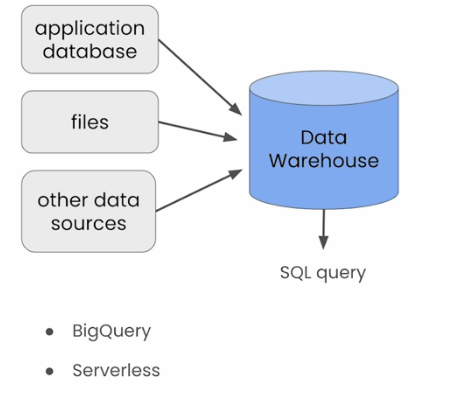

In [5]:
from google.cloud import bigquery

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID,
                            credentials = credentials)

## Stack Overflow Public Dataset

- You will use [Stack Overflow Data](https://cloud.google.com/blog/topics/public-datasets/google-bigquery-public-datasets-now-include-stack-overflow-q-a) on BigQuery Public Datasets.
- The datasets include questions, answers and metadata related to Stack Overflow questions. Within this dataset, there are tables with data.
- Create a SQL query.
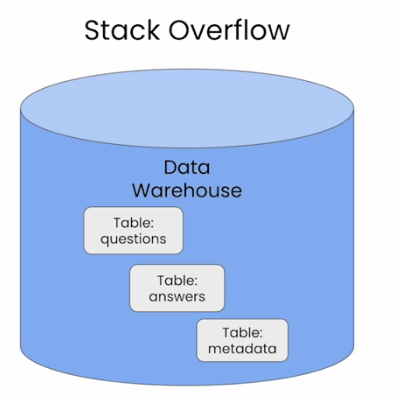

In [11]:
QUERY_TABLES = """
SELECT
  table_name
FROM
  `bigquery-public-data.stackoverflow.INFORMATION_SCHEMA.TABLES`
"""

- The query is asking to retrieve `table_name` of all the `TABLES`
- Use the client to send your SQL and retrieve the data (tables names).

In [12]:
query_job = bq_client.query(QUERY_TABLES)

In [13]:
for row in query_job:
    for value in row.values():
        print(value)

posts_answers
users
posts_orphaned_tag_wiki
posts_tag_wiki
stackoverflow_posts
posts_questions
comments
posts_tag_wiki_excerpt
posts_wiki_placeholder
posts_privilege_wiki
post_history
badges
post_links
tags
votes
posts_moderator_nomination


## Data Retrieval

- You'll fetch some data from the data warehouse and store it in Pandas dataframe for visualization.
- Select all columns from  `posts_questions` and put the `LIMIT` as 3.

In [14]:
INSPECT_QUERY = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions`
LIMIT 3
"""

In [15]:
import pandas as pd

In [16]:
query_job = bq_client.query(INSPECT_QUERY)

- Take the results of the query `-->` create an arrow table (which is part of [Apache Framework](https://arrow.apache.org/docs/index.html)) `-->` which goes into a Pandas dataframe.
- This allows for data to be in a format which is easier to read and explore with Pandas.

In [17]:
stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
stack_overflow_df.head()

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,320268,Html.ActionLink doesn’t render # properly,<p>When using Html.ActionLink passing a string...,NaN,0,0,None,2008-11-26T10:42:37.477Z,0,2009-02-06T20:13:54.370Z,None,None,NaN,Paulo,NaN,None,1,0,asp.net-mvc,390
1,324003,Primitive recursion,<p>how will i define the function 'simplify' ...,NaN,0,0,None,2008-11-27T15:12:37.497Z,0,2012-09-25T19:54:40.597Z,2012-09-25T19:54:40.597Z,Marcin,1288.0,None,41000.0,None,1,0,haskell|lambda|functional-programming|lambda-c...,497
2,390605,While vs. Do While,<p>I've seen both the blocks of code in use se...,390608.0,0,0,None,2008-12-24T01:49:54.230Z,2,2008-12-24T03:08:55.897Z,None,None,NaN,Unkwntech,115.0,None,1,0,language-agnostic|loops,11262


### Dealing with Large Datasets

- Large datasets for LLMs often don't fit into memory.
- Select all of the columns and rows of the table `posts_questions`.

In [18]:
QUERY_ALL = """
SELECT
    *
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
"""

In [19]:
query_job = bq_client.query(QUERY_ALL)

In [20]:
try:
    stack_overflow_df = query_job\
    .result()\
    .to_arrow()\
    .to_pandas()
except Exception as e:
    print('The DataFrame is too large to load into memory.', e)

The DataFrame is too large to load into memory. 403 Response too large to return. Consider specifying a destination table in your job configuration. For more details, see https://cloud.google.com/bigquery/troubleshooting-errors

Location: US
Job ID: 820c1206-8e98-4be3-a44c-ecf03874e8c3



**Note:** The data is too large to return, as it is not fitting into memory.

#### Joining Tables and Query Optimization

- When working with (large) data, query optimizing is needed in order to save time and resources.
- Select questions as `input_text` (column 1), answers as `output_text` (column 2).
- Take the questions from `posts_questions` and answers from `posts_answers`.
- Join the questions and their corresponding accepted answers based on their same `unique ID`.
- Making sure the question is about `Python`, and that it `has an answer`. And the date the question was posted is on or after `2020-01-01`
- Limit as 10,000

In [21]:
QUERY = """
SELECT
    CONCAT(q.title, q.body) as input_text,
    a.body AS output_text
FROM
    `bigquery-public-data.stackoverflow.posts_questions` q
JOIN
    `bigquery-public-data.stackoverflow.posts_answers` a
ON
    q.accepted_answer_id = a.id
WHERE
    q.accepted_answer_id IS NOT NULL AND
    REGEXP_CONTAINS(q.tags, "python") AND
    a.creation_date >= "2020-01-01"
LIMIT
    10000
"""

In [22]:
query_job = bq_client.query(QUERY)

In [23]:
stack_overflow_df = query_job.result()\
                        .to_arrow()\
                        .to_pandas()

stack_overflow_df.head(2)

,input_text,output_text
0,How can I set some clear and informative value...,"<p>From <a href=""https://github.com/allure-fra..."
1,Is it possible to find the index of elements w...,<p>Convert <code>letters</code> to a character...


### Adding Instructions

- Instructions for LLMs have been shown to improve
model performance and generalization to unseen tasks [(Google, 2022)](https://arxiv.org/pdf/2210.11416.pdf).
- Wihtout the instruction, it is only question and answer. Model might not understand what to do.
- With the instructions, the model gets a guideline as to what task to perform.

In [26]:
INSTRUCTION_TEMPLATE = f"""\
Please answer the following Stackoverflow question on Python. \
Answer it like you are a developer answering Stackoverflow questions.

Stackoverflow question:
"""

- A new column will combine `INSTRUCTION_TEMPLATE` and the question `input_text`.
- This avoids overwritting of any existing column which might be needed.

In [27]:
stack_overflow_df['input_text_instruct'] = INSTRUCTION_TEMPLATE + ' '\
    + stack_overflow_df['input_text']

### Dataset for Tuning

- Divide the data into a training and evaluation. By default, 80/20 split is used.
- This (80/20 split) allows for more data to be used for tuning. The evaluation split is used as unseen data during tuning to evaluate performance.
- The `random_state` parameter is used to ensure random sampling for a fair comparison. 

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
train, evaluation = train_test_split(
    stack_overflow_df,
    ### test_size=0.2 means 20% for evaluation
    ### which then makes train set to be of 80%
    test_size=0.2,
    random_state=42
)

#### Different Datasets and Flow

- Versioning data is important.
- It allows for reproducibility, traceability, and maintainability of machine learning models.
- Get the timestamp.

In [30]:
import datetime

In [31]:
date = datetime.datetime.now().strftime("%H:%d:%m:%Y")

- Generate a `jsonl` file.
- Name it as `tune_data_stack_overflow_python_qa-{date}`

In [43]:
cols = ['input_text_instruct','output_text']
tune_jsonl = train[cols].to_json(orient="records", lines=True)

In [44]:
training_data_filename = f"tune_data_stack_overflow_\
                            python_qa-{date}.jsonl"

In [45]:
with open(training_data_filename, "w") as f:
    f.write(tune_jsonl)

##  Evaluation Set

Generte a `jsonl` file for the `train` set. Now, its time for you to make the `evaluation` set, which you can name as `tune_eval_data_stack_overflow_python_qa-{date}.jsonl`. The code for that is also provided to you in the drop down below, but we encourage you to try it yourself first before you look at it.


In [36]:
cols = ['input_text_instruct','output_text']
### you need to use the "evaluation" set now
tune_jsonl = evaluation[cols].to_json(orient="records", lines=True)

### change the file name
### use "tune_eval_data_stack_overflow_python_qa-{date}.jsonl"
evaluation_data_filename = f"tune_eval_data_stack_overflow_\
                            python_qa-{date}.jsonl"

### write the file
with open(evaluation_data_filename, "w") as f:
    f.write(tune_jsonl)
